In [ ]:
import os
import codecs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from dotenv import load_dotenv

load_dotenv()

True

In [33]:
def load_mnist():
    path_to_data = os.environ.get("MNIST_DATAPATH")
    mnist_files = os.listdir(path_to_data)
    mnist_files = [x for x in mnist_files if x.endswith("ubyte")]


    def convert_to_int(byte):
        integer = int(codecs.encode(byte, 'hex'), 16)
        return integer


    dataset = {}
    for file in mnist_files:
        print("Reading", file)
        with open(path_to_data + file, "rb") as f:
            data = f.read()
            type_of_data = convert_to_int(data[:4])
            length = convert_to_int(data[4:8])
            if type_of_data == 2051:
                category = "images"
                number_of_rows = convert_to_int(data[8:12])
                number_of_columns = convert_to_int(data[12:16])
                parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
                parsed = parsed.reshape(length, number_of_rows, number_of_columns)
            if type_of_data == 2049:
                category = "labels"
                parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
                parsed = parsed.reshape(length)
            if length == 60000:
                set = "train"
            if length == 10000:
                set = "test"
            dataset[set + '_' + category] = parsed

    print(dataset["train_images"][0, :, :])

    train_images = dataset['train_images']
    train_labels = dataset['train_labels']
    train_images_flattened = train_images.reshape(60000, -1)
    train_images_flattened = train_images_flattened / 255
    train_images_flattened -= np.mean(train_images_flattened, axis=0)


    test_images = dataset['train_images']
    test_images = dataset['train_labels']
    test_images_flattened = test_images.reshape(10000, -1)
    test_images_flattened = test_images_flattened / 255
    test_images_flattened -= np.mean(test_images_flattened, axis=0)



    indexes = np.random.choice(60000, size=5000, replace=False)
    train_images = train_images_flattened[indexes]
    train_labels = train_labels[indexes]
    return train_images, train_labels


def compute_perplexity(D, beta=0.6, tol=1e-5, max_iter=50):
    """ Binary search to find the optimal beta for each row to match the target perplexity """
    N = D.shape[0]
    P = np.zeros_like(D)
    betas = np.full(N, beta)
    log_perp = np.log2(30)
    
    for i in range(N):
        beta_min, beta_max = -np.inf, np.inf
        Di = D[i, np.arange(N) != i]  # Exclude self-distance
        H_diff = 1
        iter_count = 0
        
        while np.abs(H_diff) > tol and iter_count < max_iter:
            P_i = np.exp(-Di * betas[i])
            P_i /= np.sum(P_i)
            H = -np.sum(P_i * np.log2(P_i))
            H_diff = H - log_perp
            
            if H_diff > 0:
                beta_min = betas[i]
                betas[i] = (betas[i] + beta_max) / 2 if beta_max != np.inf else betas[i] * 2
            else:
                beta_max = betas[i]
                betas[i] = (betas[i] + beta_min) / 2 if beta_min != -np.inf else betas[i] / 2
            
            iter_count += 1
        
        P[i, np.arange(N) != i] = P_i
    
    return P


# Compute pairwise distances and similarities
def compute_p_matrix(X, perplexity=30):
    """ Compute pairwise distance matrix and similarity matrix """
    D = pairwise_distances(X, squared=True)
    P = compute_perplexity(D, beta=0.6)
    np.fill_diagonal(P, 0)  # Zero diagonal
    P = (P + P.T) / 2  # Symmetric
    P /= np.sum(P)  # Normalize
    return P



# Compute t-SNE

def tsne(X, labels, n_components=2, n_iter=400, learning_rate=500, momentum=True):
    """ Runs t-SNE algorithm on the dataset """
    N = X.shape[0]
    P = compute_p_matrix(X)
    
    # Initialize variables
    Y = np.random.randn(N, n_components) * 0.0001
    Y_incs = np.zeros_like(Y)
    gains = np.ones_like(Y)
    min_gain = 0.01
    
    for iter in range(1, n_iter + 1):
        sum_Y2 = np.sum(Y ** 2, axis=1)
        Q_num = 1 / (1 + sum_Y2[:, None] + sum_Y2[None, :] - 2 * (Y @ Y.T))
        np.fill_diagonal(Q_num, 0)
        Q = Q_num / np.sum(Q_num)
        
        # Compute gradient
        L = (P - Q) * Q_num
        y_grads = 4 * (np.diag(np.sum(L, axis=1)) - L) @ Y
        
        # Momentum update
        if momentum:
            gains = (gains + 0.2) * (np.sign(y_grads) != np.sign(Y_incs)) + (gains * 0.8) * (np.sign(y_grads) == np.sign(Y_incs))
            gains[gains < min_gain] = min_gain
            Y_incs = -learning_rate * (gains * y_grads)
        else:
            Y_incs = -learning_rate * y_grads
        
        Y += Y_incs
        Y -= np.mean(Y, axis=0)  # Center Y
        
        # Print cost and plot every 10 iterations
        if iter % 10 == 0:
            cost = np.sum(P * np.log(P / Q))
            print(f"Iteration {iter}: error = {cost:.4f}")
            plt.figure(figsize=(6, 5))
            plt.scatter(Y[:, 0], Y[:, 1], c=labels, cmap="tab10", s=2)
            plt.title(f"t-SNE Iteration {iter}")
            plt.show()
    
    return Y

Reading t10k-images-idx3-ubyte
Reading t10k-labels-idx1-ubyte
Reading train-images-idx3-ubyte
Reading train-labels-idx1-ubyte
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 2

/var/folders/9d/hd3srjbx4rgbbrvnwxmcmh9c0000gn/T/ipykernel_43729/3465620598.py:139: RuntimeWarning: invalid value encountered in divide
  cost = np.sum(P * np.log(P / Q))


Iteration 10: error = nan


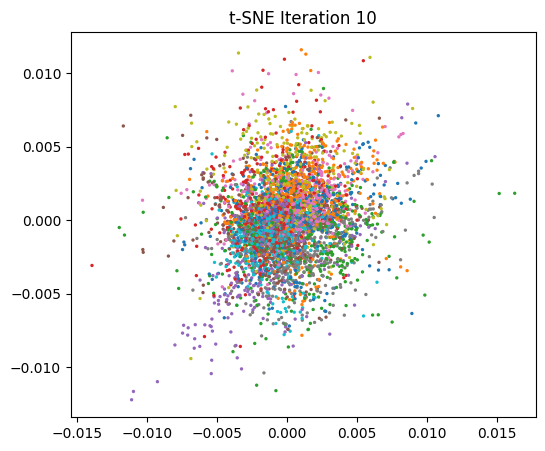

Iteration 20: error = nan


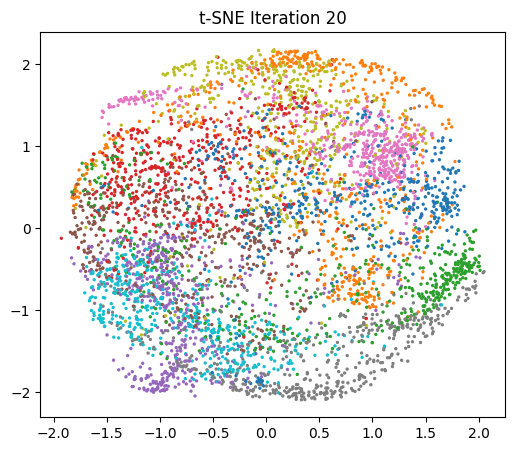

Iteration 30: error = nan


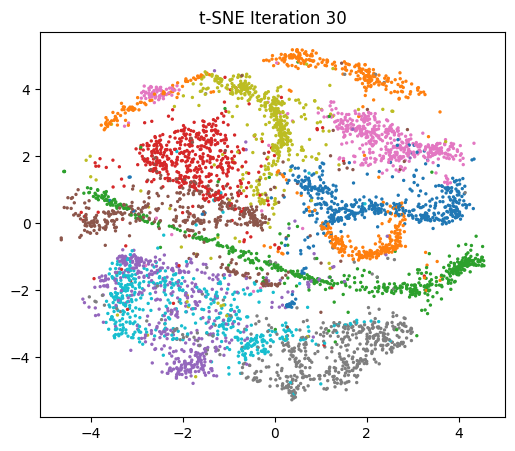

Iteration 40: error = nan


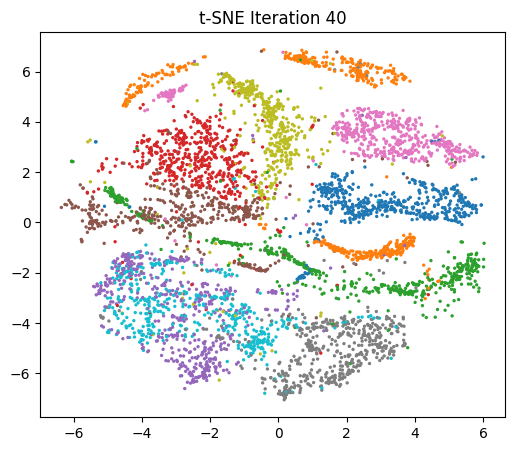

Iteration 50: error = nan


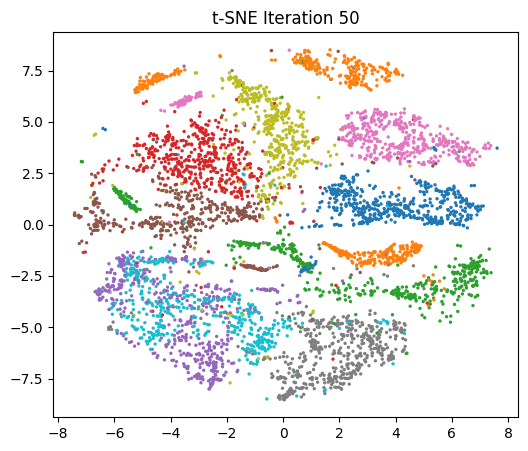

Iteration 60: error = nan


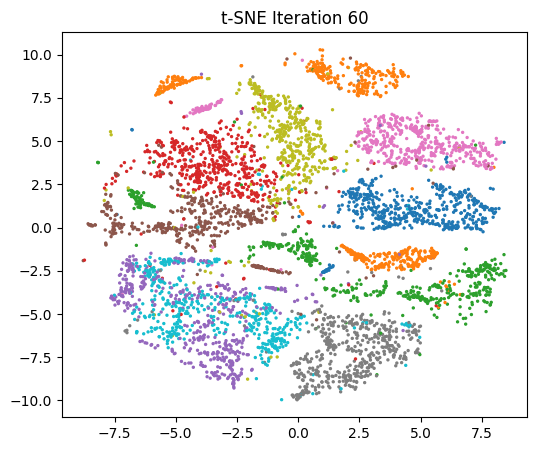

Iteration 70: error = nan


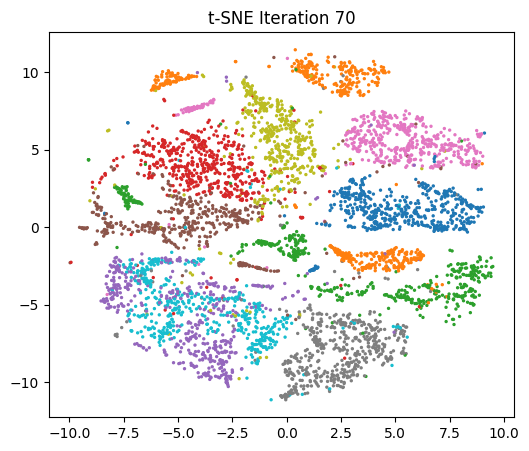

Iteration 80: error = nan


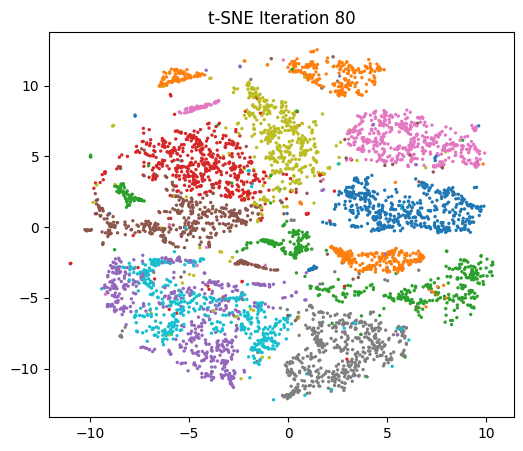

Iteration 90: error = nan


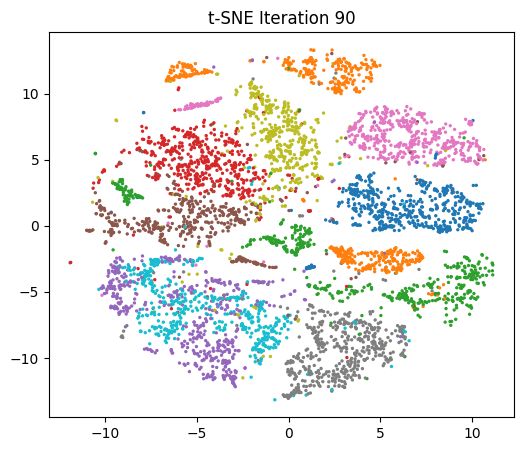

Iteration 100: error = nan


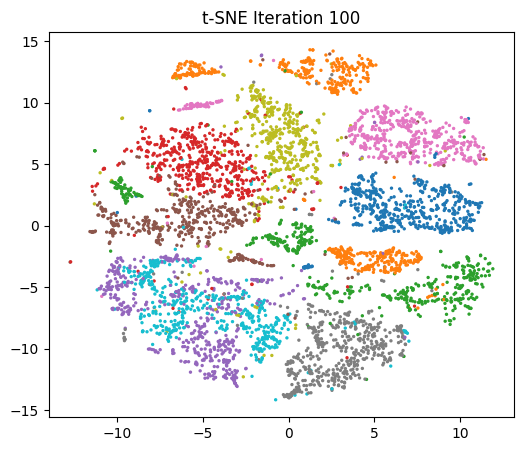

Iteration 110: error = nan


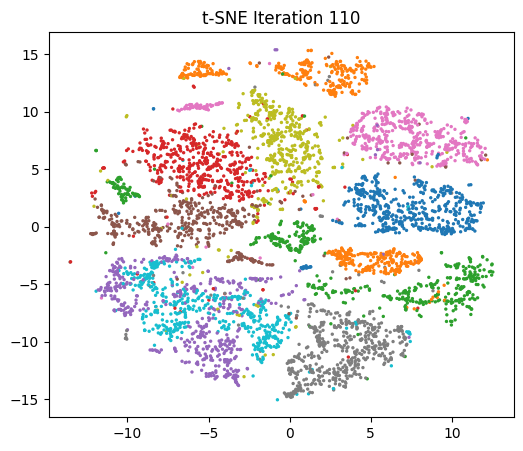

Iteration 120: error = nan


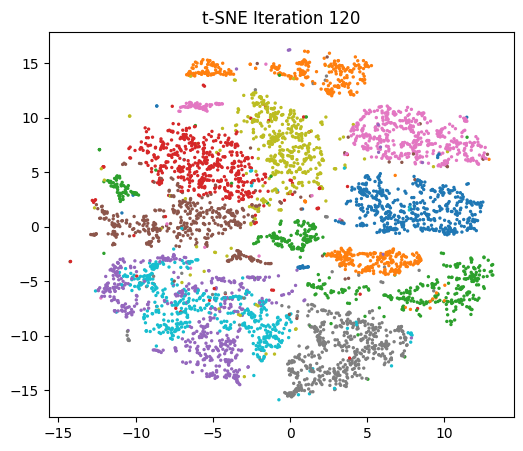

Iteration 130: error = nan


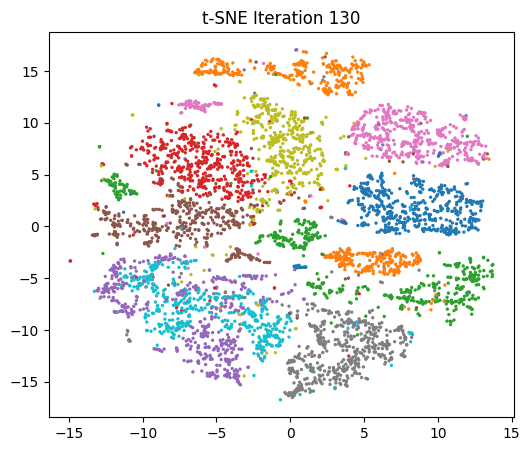

Iteration 140: error = nan


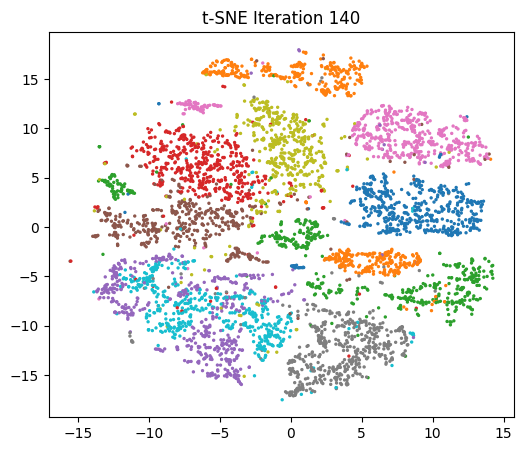

Iteration 150: error = nan


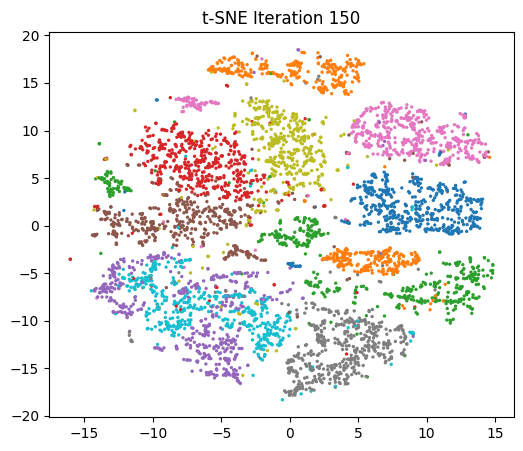

Iteration 160: error = nan


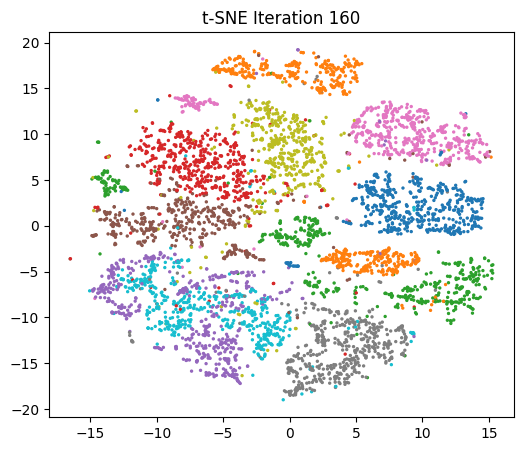

Iteration 170: error = nan


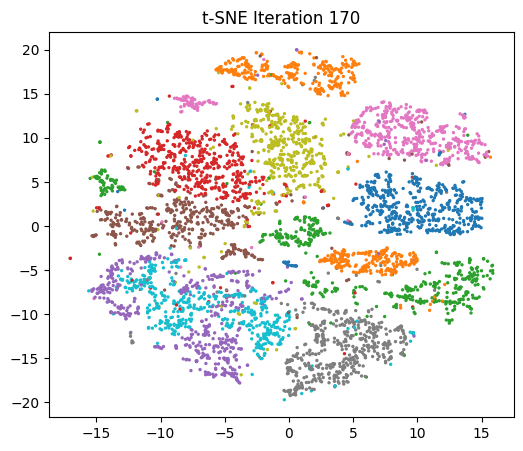

Iteration 180: error = nan


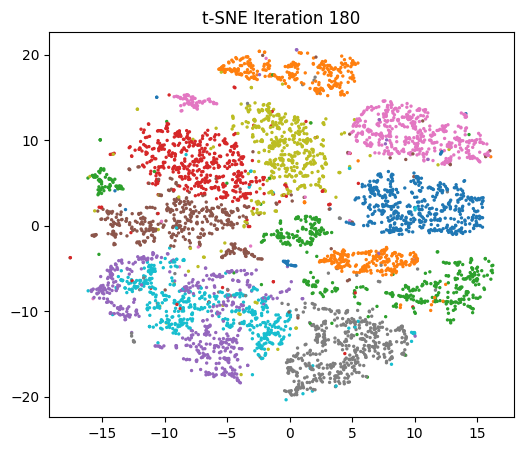

Iteration 190: error = nan


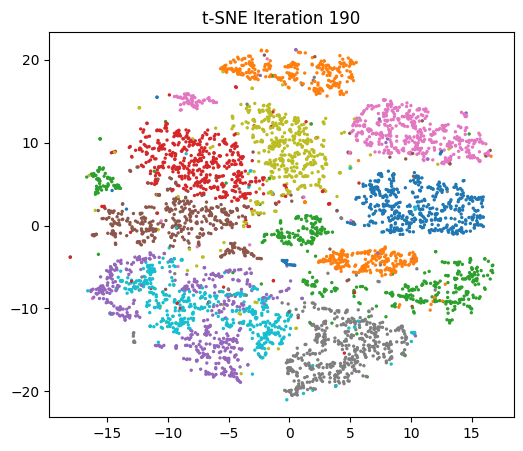

Iteration 200: error = nan


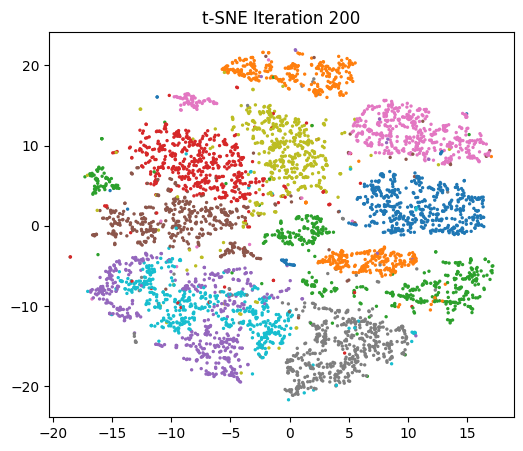

Iteration 210: error = nan


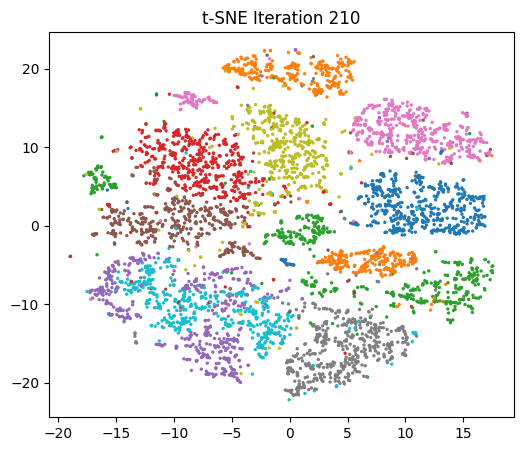

Iteration 220: error = nan


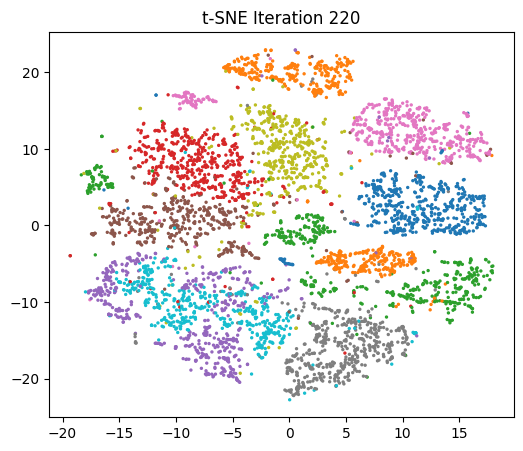

Iteration 230: error = nan


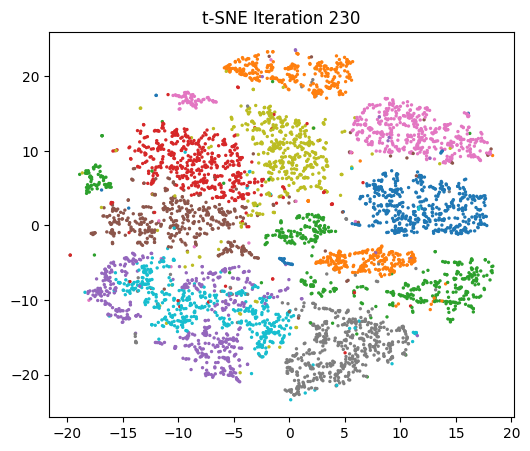

Iteration 240: error = nan


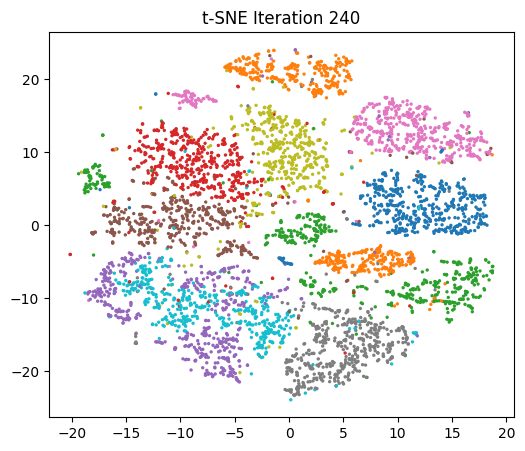

Iteration 250: error = nan


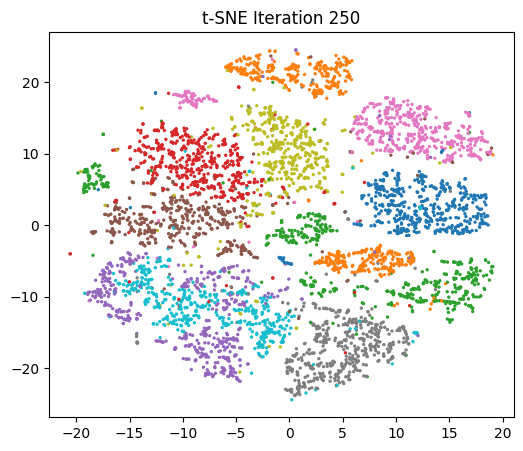

Iteration 260: error = nan


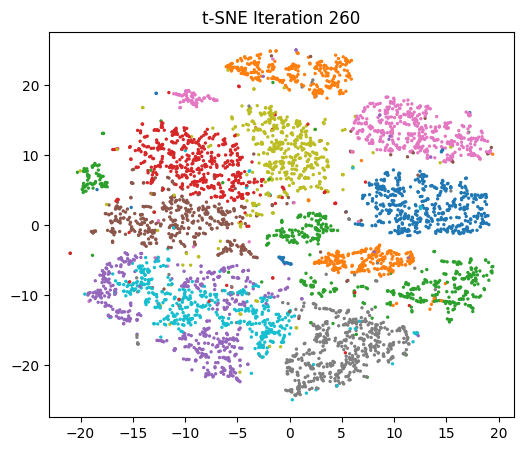

Iteration 270: error = nan


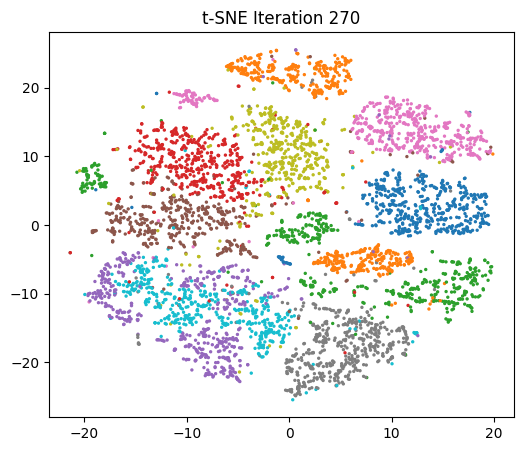

Iteration 280: error = nan


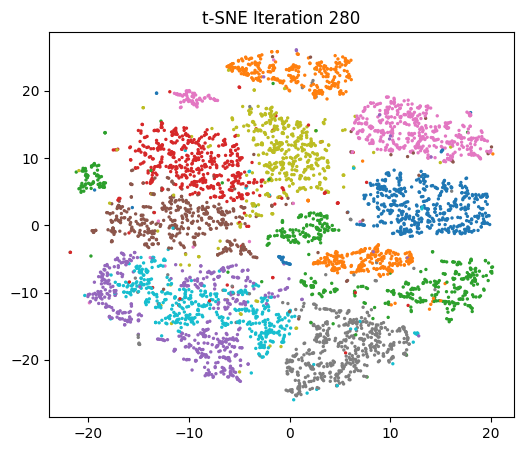

Iteration 290: error = nan


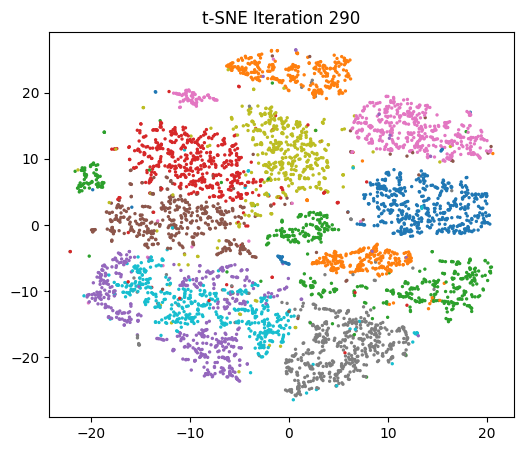

Iteration 300: error = nan


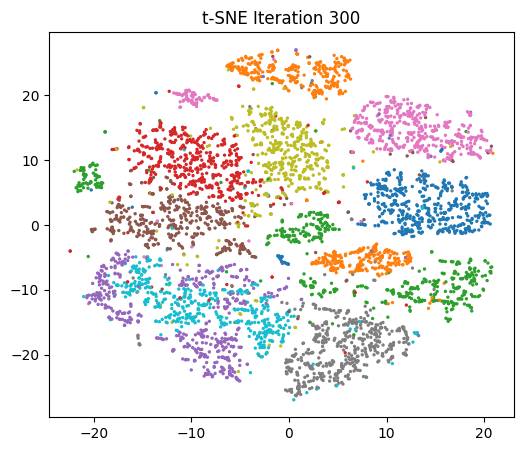

Iteration 310: error = nan


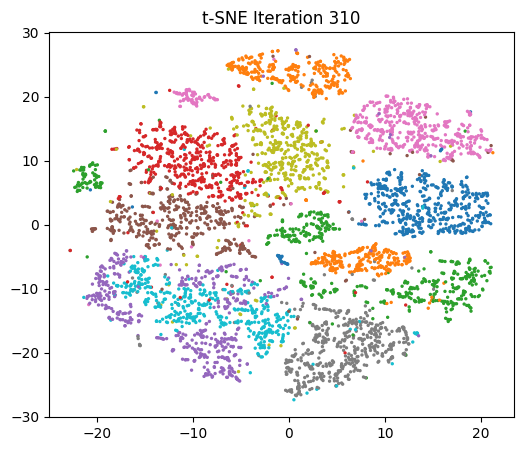

Iteration 320: error = nan


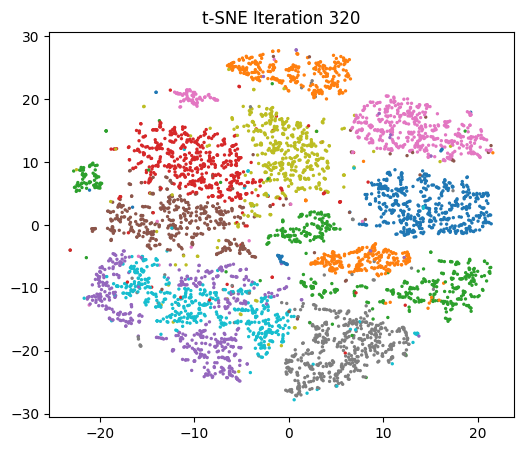

Iteration 330: error = nan


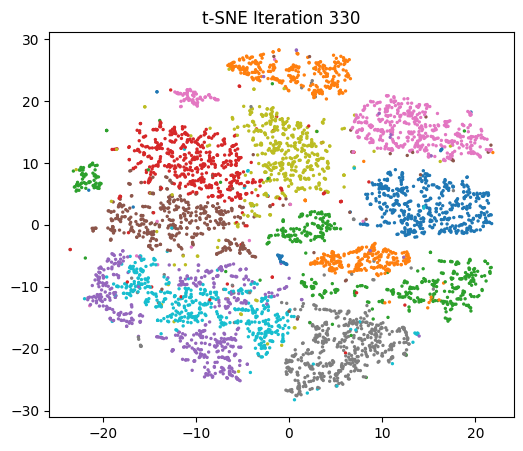

Iteration 340: error = nan


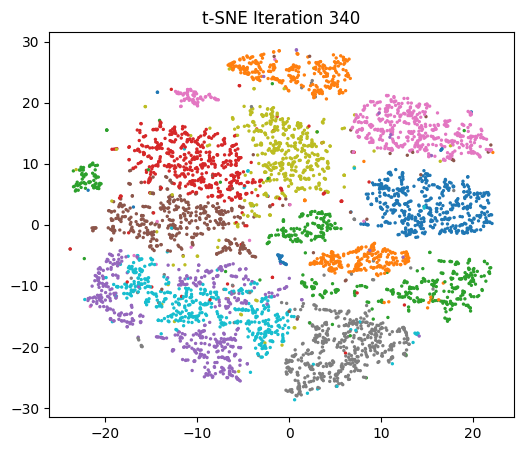

Iteration 350: error = nan


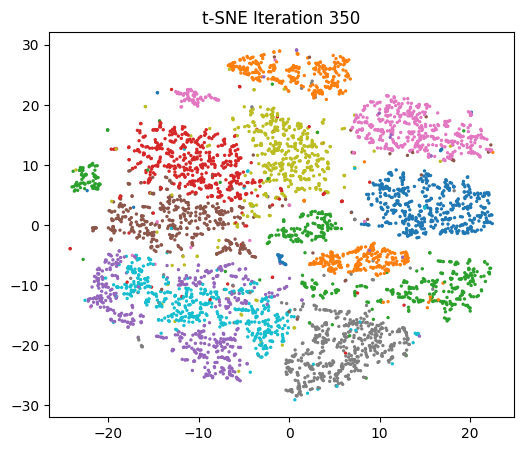

Iteration 360: error = nan


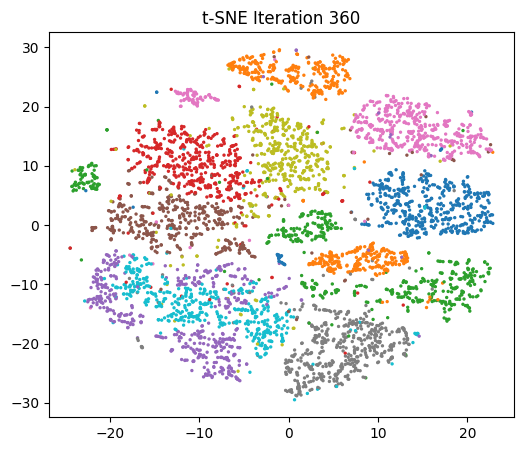

Iteration 370: error = nan


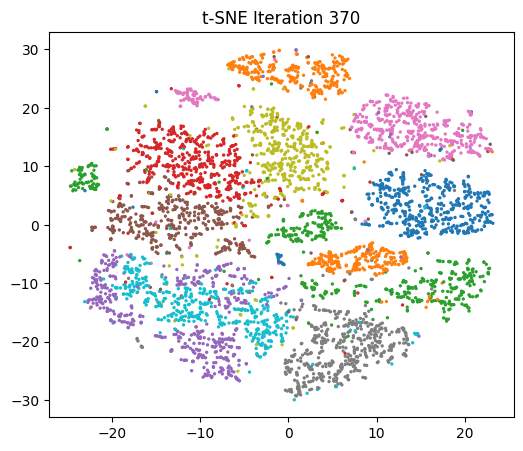

Iteration 380: error = nan


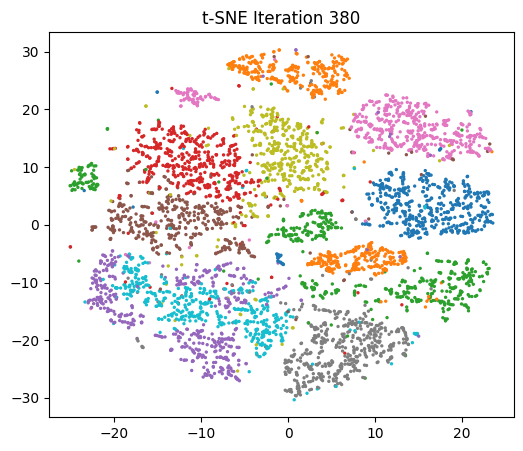

Iteration 390: error = nan


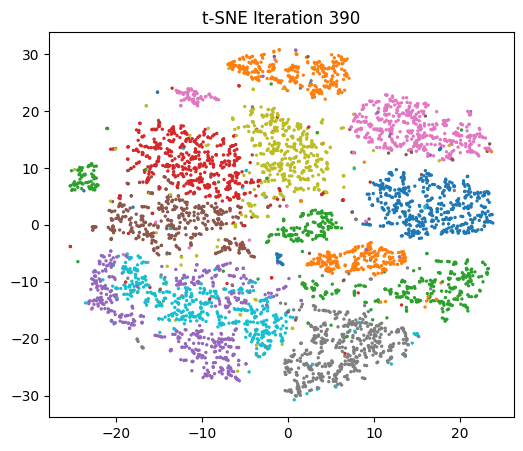

Iteration 400: error = nan


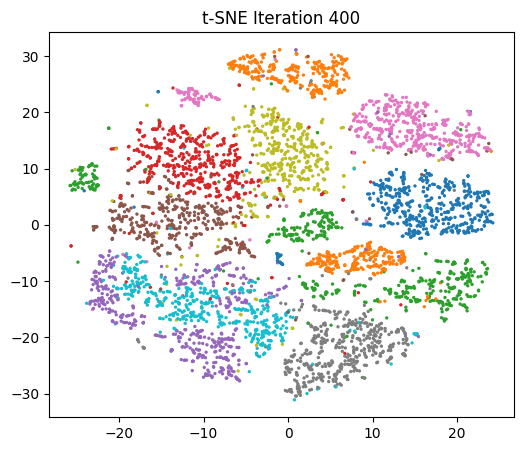

(5000, 2)


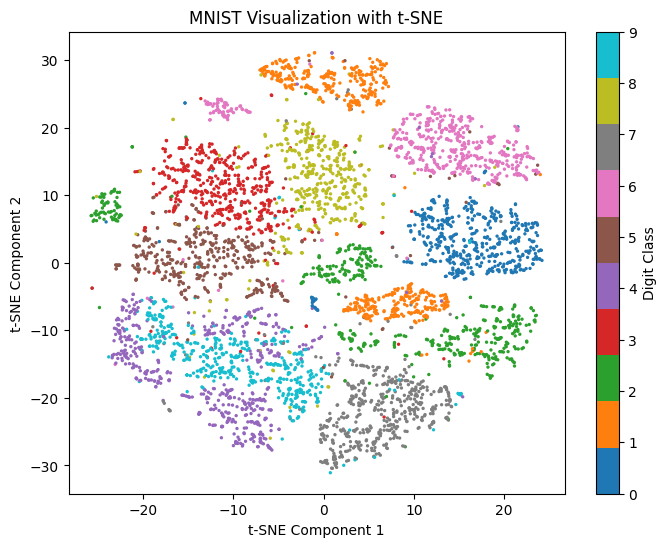

In [34]:
X, labels = load_mnist()

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

X_tsne = tsne(X_pca, labels)

print(X_tsne.shape)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap="tab10", s=2)
plt.colorbar(scatter, label="Digit Class")
plt.title("MNIST Visualization with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()